In [79]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

log2 = tf.math.log(2.0)
log2_lookup_np = np.log2(np.arange(1, 257))
log2_lookup = tf.constant(log2_lookup_np, dtype=tf.float32)

# Logarithmic quantization functions
def int_frac(x):
    x_clipped = tf.clip_by_value(x, 0.01, 256.0)
    int_part = tf.cast(tf.math.floor(x_clipped), tf.int32)
    fraction_part = x_clipped - tf.cast(int_part, tf.float32)
    return int_part, fraction_part

def taylor_approx(x, n_terms=2):
    x_clipped = tf.clip_by_value(x, 0.01, 256.0)
    int_part, fraction_part = int_frac(x_clipped)
    log2_int_part = tf.gather(log2_lookup, tf.clip_by_value(int_part, 0, 255))
    log2_fraction_part = fraction_part / log2  
    return log2_int_part + log2_fraction_part

def log_quantize(x):
    log2_x = taylor_approx(x, n_terms=2)
    return log2_x

# Custom CNN model with log-quantized operations
class LogCNN(tf.keras.Model):
    def __init__(self, input_shape, num_classes):
        super(LogCNN, self).__init__()
        self.conv1 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')
        self.pool1 = layers.MaxPooling2D((2, 2))
        self.conv3 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.bn2 = layers.BatchNormalization()
        self.pool2 = layers.MaxPooling2D((2, 2))
        self.conv4 = layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.bn3 = layers.BatchNormalization()
        self.pool3 = layers.MaxPooling2D((2, 2))
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(256, activation='relu')
        self.bn4 = layers.BatchNormalization()
        self.fc2 = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        # Apply log quantization to inputs
        x = log_quantize(inputs)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.bn2(x)
        x = self.pool2(x)
        x = self.conv4(x)
        x = self.bn3(x)
        x = self.pool3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn4(x)
        x = self.fc2(x)
        return x

if __name__ == "__main__":
    # Load MNIST dataset
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = x_train.astype("float32") / 255.0
    x_test = x_test.astype("float32") / 255.0
    x_train = np.expand_dims(x_train, -1)
    x_test = np.expand_dims(x_test, -1)
    x_train = tf.image.resize(x_train, (32, 32))
    x_test = tf.image.resize(x_test, (32, 32))

    # One-hot encode labels
    y_train = tf.keras.utils.to_categorical(y_train, 10)
    y_test = tf.keras.utils.to_categorical(y_test, 10)

    # Define model
    input_shape = (32, 32, 1)
    num_classes = 10
    model = LogCNN(input_shape, num_classes)
    
    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss="categorical_crossentropy", metrics=["accuracy"])
    
    # Train model
    model.fit(x_train, y_train, batch_size=64, epochs=10, validation_split=0.2)
    
    # Evaluate model
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
    print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 31s 38ms/step - accuracy: 0.8926 - loss: 0.3308 - val_accuracy: 0.9825 - val_loss: 0.0559
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - accuracy: 0.9870 - loss: 0.0413 - val_accuracy: 0.9828 - val_loss: 0.0547
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - accuracy: 0.9925 - loss: 0.0251 - val_accuracy: 0.9886 - val_loss: 0.0352
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.9944 - loss: 0.0175 - val_accuracy: 0.9908 - val_loss: 0.0350
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 29s 39ms/step - accuracy: 0.9942 - loss: 0.0161 - val_accuracy: 0.9898 - val_loss: 0.0389
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 28s 38ms/step - accuracy: 0.9960 - loss: 0.0123 - val_accuracy: 0.9920 - val_loss: 0.0291
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 29s 39ms/step - accuracy: 0.9970 - loss: 0.0091 - val_accuracy: 0.9903 - val_loss: 0.0401
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9971 - loss: 0.0100

KeyboardInterrupt: 

In [73]:
from PIL import Image

image_path = "C:/Users/prabh/OneDrive/Desktop/MNIST classifiers/example.png"
image = Image.open(image_path).convert("L")
image = image.resize((32, 32))
image_array = np.array(image).astype("float32") / 255.0
image_array = np.expand_dims(image_array, axis=(0, -1))

predictions = model.predict(image_array)
predicted_class = np.argmax(predictions)

print(f"Predicted Class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predicted Class: 8


In [15]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

log2 = tf.math.log(2.0)
log2_lookup_np = np.log2(np.arange(1, 257))
log2_lookup = tf.constant(log2_lookup_np, dtype=tf.float32)

# Logarithmic quantization functions
def int_frac(x):
    x_clipped = tf.clip_by_value(x, 0.01, 256.0)
    int_part = tf.cast(tf.math.floor(x_clipped), tf.int32)
    fraction_part = x_clipped - tf.cast(int_part, tf.float32)
    return int_part, fraction_part

def taylor_approx(x, n_terms=2):
    x_clipped = tf.clip_by_value(x, 0.01, 256.0)
    int_part, fraction_part = int_frac(x_clipped)
    log2_int_part = tf.gather(log2_lookup, tf.clip_by_value(int_part, 0, 255))
    log2_fraction_part = fraction_part / log2  
    return log2_int_part + log2_fraction_part

def log_quantize(x):
    log2_x = taylor_approx(x, n_terms=2)
    return log2_x

# Custom CNN model with log-quantized weight multiplication
class LogCNN(tf.keras.Model):
    def __init__(self, input_shape, num_classes):
        super(LogCNN, self).__init__()
        self.conv1 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')
        self.pool1 = layers.MaxPooling2D((2, 2))
        self.conv3 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.bn2 = layers.BatchNormalization()
        self.pool2 = layers.MaxPooling2D((2, 2))
        self.conv4 = layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.bn3 = layers.BatchNormalization()
        self.pool3 = layers.MaxPooling2D((2, 2))
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(256, activation='relu')
        self.bn4 = layers.BatchNormalization()
        self.fc2 = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        # Log-quantize inputs
        x = log_quantize(inputs)
        
        # Apply layers with quantized weights
        x = self.conv1(x)
        x = log_quantize(x)  # Quantize after the layer
        x = self.bn1(x)
        x = self.conv2(x)
        x = log_quantize(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = log_quantize(x)
        x = self.bn2(x)
        x = self.pool2(x)
        x = self.conv4(x)
        x = log_quantize(x)
        x = self.bn3(x)
        x = self.pool3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = log_quantize(x)
        x = self.bn4(x)
        x = self.fc2(x)
        return x

if __name__ == "__main__":
    # Load MNIST dataset
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = x_train.astype("float32") / 255.0
    x_test = x_test.astype("float32") / 255.0
    x_train = np.expand_dims(x_train, -1)
    x_test = np.expand_dims(x_test, -1)
    x_train = tf.image.resize(x_train, (32, 32))
    x_test = tf.image.resize(x_test, (32, 32))

    # One-hot encode labels
    y_train = tf.keras.utils.to_categorical(y_train, 10)
    y_test = tf.keras.utils.to_categorical(y_test, 10)

    # Define model
    input_shape = (32, 32, 1)
    num_classes = 10
    model = LogCNN(input_shape, num_classes)
    
    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss="categorical_crossentropy", metrics=["accuracy"])
    
    # Train model
    model.fit(x_train, y_train, batch_size=64, epochs=10, validation_split=0.2)
    
    # Evaluate model
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
    print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 62s 79ms/step - accuracy: 0.8060 - loss: 0.6130 - val_accuracy: 0.9430 - val_loss: 0.1718
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 53s 70ms/step - accuracy: 0.9487 - loss: 0.1617 - val_accuracy: 0.9556 - val_loss: 0.1394
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 53s 71ms/step - accuracy: 0.9579 - loss: 0.1300 - val_accuracy: 0.9619 - val_loss: 0.1217
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 68s 91ms/step - accuracy: 0.9682 - loss: 0.1022 - val_accuracy: 0.9710 - val_loss: 0.0939
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 97s 129ms/step - accuracy: 0.9677 - loss: 0.0994 - val_accuracy: 0.9592 - val_loss: 0.1327
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 98s 131ms/step - accuracy: 0.9616 - loss: 0.1120 - val_accuracy: 0.9707 - val_loss: 0.0930
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 90s 120ms/step - accuracy: 0.9707 - loss: 0.0921 - val_accuracy: 0.9665 - val_loss: 0.1033
Epoch 8/10
232/750 ━━━━━━━━━━━━━━━━━━━━ 50s 97ms/step - accuracy: 0.9748 - loss: 0.0838

KeyboardInterrupt: 

In [39]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

log2 = tf.math.log(2.0)
log2_lookup_np = np.log2(np.arange(1, 257))
log2_lookup = tf.constant(log2_lookup_np, dtype=tf.float32)

# Logarithmic quantization functions
def int_frac(x):
    x_clipped = tf.clip_by_value(x, 0.01, 256.0)
    int_part = tf.cast(tf.math.floor(x_clipped), tf.int32)
    fraction_part = x_clipped - tf.cast(int_part, tf.float32)
    return int_part, fraction_part

def taylor_approx(x, n_terms=2):
    x_clipped = tf.clip_by_value(x, 0.01, 256.0)
    int_part, fraction_part = int_frac(x_clipped)
    log2_int_part = tf.gather(log2_lookup, tf.clip_by_value(int_part, 0, 255))
    log2_fraction_part = fraction_part / log2  
    return log2_int_part + log2_fraction_part

def log_quantize(x):
    log2_x = taylor_approx(x, n_terms=2)
    return log2_x

# Custom CNN model with log-quantized weight multiplication
class LogCNN(tf.keras.Model):
    def __init__(self, input_shape, num_classes):
        super(LogCNN, self).__init__()
        self.conv1 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')
        self.pool1 = layers.MaxPooling2D((2, 2))
        self.conv3 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.bn2 = layers.BatchNormalization()
        self.pool2 = layers.MaxPooling2D((2, 2))
        self.conv4 = layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.bn3 = layers.BatchNormalization()
        self.pool3 = layers.MaxPooling2D((2, 2))
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(256, activation='relu')
        self.bn4 = layers.BatchNormalization()
        self.fc2 = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
         x = log_quantize(inputs)
         x = self.conv1(x)
        x = log_quantize(x)   
        x = self.bn1(x)
        x = self.conv2(x)
        x = log_quantize(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = log_quantize(x)
        x = self.bn2(x)
        x = self.pool2(x)
        x = self.conv4(x)
        x = log_quantize(x)
        x = self.bn3(x)
        x = self.pool3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = log_quantize(x)
        x = self.bn4(x)
        x = self.fc2(x)
        return x

if __name__ == "__main__":
    # Load MNIST dataset
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = x_train.astype("float32") / 255.0
    x_test = x_test.astype("float32") / 255.0
    x_train = np.expand_dims(x_train, -1)
    x_test = np.expand_dims(x_test, -1)
    x_train = tf.image.resize(x_train, (32, 32))
    x_test = tf.image.resize(x_test, (32, 32))

    # One-hot encode labels
    y_train = tf.keras.utils.to_categorical(y_train, 10)
    y_test = tf.keras.utils.to_categorical(y_test, 10)

    # Define model
    input_shape = (32, 32, 1)
    num_classes = 10
    model = LogCNN(input_shape, num_classes)
    
    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss="categorical_crossentropy", metrics=["accuracy"])
    
    # Train model
    model.fit(x_train, y_train, batch_size=64, epochs=10, validation_split=0.2)
    
    # Evaluate model
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
    print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 46s 57ms/step - accuracy: 0.8840 - loss: 0.3666 - val_accuracy: 0.9775 - val_loss: 0.0702
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 45s 59ms/step - accuracy: 0.9818 - loss: 0.0578 - val_accuracy: 0.9823 - val_loss: 0.0544
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 46s 61ms/step - accuracy: 0.9840 - loss: 0.0484 - val_accuracy: 0.9798 - val_loss: 0.0642
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 46s 62ms/step - accuracy: 0.9851 - loss: 0.0462 - val_accuracy: 0.9847 - val_loss: 0.0463
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 47s 62ms/step - accuracy: 0.9882 - loss: 0.0373 - val_accuracy: 0.9826 - val_loss: 0.0578
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 47s 62ms/step - accuracy: 0.9900 - loss: 0.0314 - val_accuracy: 0.9870 - val_loss: 0.0461
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 47s 62ms/step - accuracy: 0.9906 - loss: 0.0291 - val_accuracy: 0.9877 - val_loss: 0.0408
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 47s 62ms/step - accuracy: 0.9925 - loss: 0.0241 - 

In [41]:
model.build(input_shape=(None, *input_shape))
model.summary()


Model: "log_cnn_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)                   │ (64, 32, 32, 32)            │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (64, 32, 32, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (64, 32, 32, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (64, 16, 16, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (64, 16, 16, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (64, 8, 8, 128)             │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (64, 8, 8, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_13 (Flatten)                 │ (64, 2048)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (64, 256)                   │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (64, 256)                   │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (64, 10)                    │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,890,944 (7.21 MB)

 Trainable params: 629,994 (2.40 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 1,259,990 (4.81 MB)

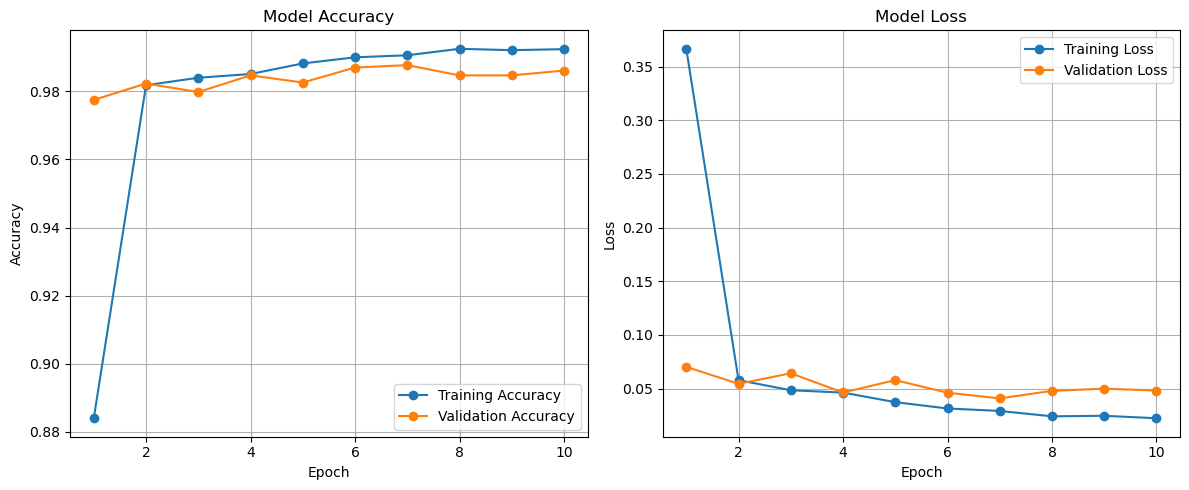

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Data extracted from the epochs
epochs = np.arange(1, 11)
accuracy = [0.8840, 0.9818, 0.9840, 0.9851, 0.9882, 0.9900, 0.9906, 0.9925, 0.9921, 0.9924]
loss = [0.3666, 0.0578, 0.0484, 0.0462, 0.0373, 0.0314, 0.0291, 0.0241, 0.0246, 0.0223]
val_accuracy = [0.9775, 0.9823, 0.9798, 0.9847, 0.9826, 0.9870, 0.9877, 0.9847, 0.9847, 0.9861]
val_loss = [0.0702, 0.0544, 0.0642, 0.0463, 0.0578, 0.0461, 0.0408, 0.0478, 0.0499, 0.0481]

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


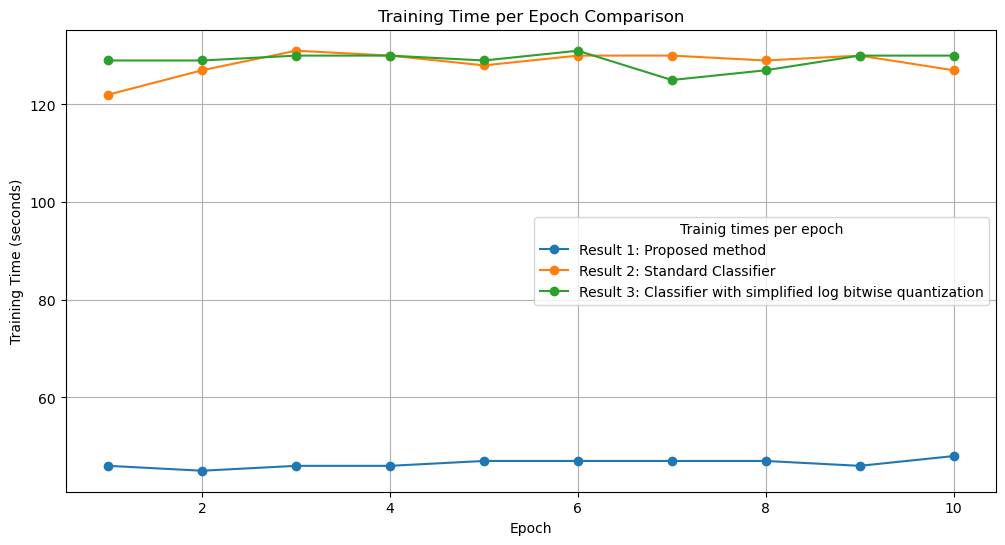

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Training time per epoch (in seconds) for each result
time_result_1 = [46, 45, 46, 46, 47, 47, 47, 47, 46, 48]  # First set
time_result_2 = [122, 127, 131, 130, 128, 130, 130, 129, 130, 127]  # Second set
time_result_3 = [129, 129, 130, 130, 129, 131, 125, 127, 130, 130]  # Third set

epochs = np.arange(1, 11)

# Plot the training time
plt.figure(figsize=(12, 6))
plt.plot(epochs, time_result_1, label='Result 1: Proposed method', marker='o')
plt.plot(epochs, time_result_2, label='Result 2: Standard Classifier', marker='o')
plt.plot(epochs, time_result_3, label='Result 3: Classifier with simplified log bitwise quantization', marker='o')
plt.title('Training Time per Epoch Comparison')
plt.xlabel('Epoch')
plt.ylabel('Training Time (seconds)')
plt.legend(title='Trainig times per epoch', loc='center right')  # Adding a title to the legend for clarity
plt.grid()
plt.show()
